In [18]:
# Gerekli kütüphaneleri yükleyin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import faiss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from transformers import RagTokenizer, RagRetriever, RagSequenceForGeneration
import torch
from datasets import load_dataset
from transformers import DPRQuestionEncoderTokenizer, DPRQuestionEncoder




In [2]:
# pandasın ayarlarını güncelleyerek her kolonu ve ilk 10 satırını vermesini sağlıyoruz
pd.set_option('display.max_columns', None)  # Tüm kolonları göster
pd.set_option('display.max_rows', 10)  # Her kolonun ilk 10 satırını göster

# Log dosyasını yükleyin
file_path = './web_traffic.log'
with open(file_path, 'r') as file:
    logs = file.readlines()

# Log verilerini DataFrame'e dönüştür
def parse_log(log_line):
    # Log formatına uygun düzenli ifadeyi kullanarak verileri ayır
    pattern = r'(\S+) - - \[(.*?)\] "(\S+) (\S+) HTTP/1.1" (\d+) (\d+)'
    match = re.match(pattern, log_line)
    if match:
        ip, timestamp, method, endpoint, status, size = match.groups()
        return ip, timestamp, method, endpoint, status, size
    return None

# Verileri ayıklama ve DataFrame oluşturma
data = [parse_log(line) for line in logs]
df = pd.DataFrame(data, columns=['IP', 'Timestamp', 'Method', 'Endpoint', 'Status', 'Size'])
df_backup = df # ilerleyen zamanlarda dataframeden veri kaybetmemiz durumunda bu dataframe ile eşitleyerek veri kaybını önleyeceğiz

# İlk birkaç satırı görüntüle
print(df.head(10))


                IP                   Timestamp  Method             Endpoint  \
0      32.32.61.41  05/Jun/2001:03:32:13 +0000    POST               /about   
1     31.156.84.68  31/Aug/1996:05:06:28 +0000    POST              /signup   
2  111.224.206.188  26/Dec/1974:05:31:04 +0000     PUT  /products/item?id=2   
3       3.35.216.7  08/Apr/2023:10:38:31 +0000    POST            /products   
4    43.163.88.139  02/Jul/2020:17:50:02 +0000  DELETE               /login   
5   14.177.206.174  16/Aug/1985:06:05:49 +0000     PUT  /products/item?id=1   
6   152.231.83.225  18/Sep/1979:16:15:04 +0000    POST              /signup   
7   151.40.216.114  08/May/1979:18:36:27 +0000    POST                /home   
8     27.9.236.143  05/Sep/2002:09:04:22 +0000  DELETE               /about   
9     22.156.71.77  06/Jun/1975:06:37:42 +0000    POST            /products   

  Status  Size  
0    301  1363  
1    200  2512  
2    500  1154  
3    200  2962  
4    500   207  
5    200  2180  
6    301   

# Web Trafik Logları Veri Açıklaması

Bu belgede, web trafik loglarının içerdiği kolonlar ve verilerin detayları açıklanacaktır.

## Veri Seti Kolonları

### 1. **IP**
- **Açıklama:** Web isteğini yapan istemcinin IP adresi.
- **Örnek:** `32.32.61.41`
- **Tür:** String

### 2. **Timestamp**
- **Açıklama:** Web isteğinin yapıldığı tarih ve saat.
- **Format:** `[dd/mmm/yyyy:hh:mm:ss +0000]`
- **Örnek:** `05/Jun/2001:03:32:13 +0000`
- **Tür:** String (Daha sonra tarih/zaman formatına dönüştürülecek)

### 3. **Method**
- **Açıklama:** Web isteğinde kullanılan HTTP yöntemi.
- **Değerler:** `GET`, `POST`, `PUT`, `DELETE`, vb.
- **Örnek:** `POST`
- **Tür:** String

### 4. **Endpoint**
- **Açıklama:** Web isteğinin yapıldığı URL'nin yolu.
- **Örnek:** `/about`, `/signup`, `/products/item?id=2`
- **Tür:** String

### 5. **Status**
- **Açıklama:** Web isteğine verilen HTTP yanıt durumu kodu.
- **Değerler:** `200` (Başarılı), `301` (Kalıcı Yönlendirme), `500` (Sunucu Hatası), vb.
- **Örnek:** `301`
- **Tür:** Integer

### 6. **Size**
- **Açıklama:** Web isteği yanıtının boyutu (bayt cinsinden).
- **Örnek:** `1363`, `2512`
- **Tür:** Integer


In [3]:
print(df.shape)
print(df.columns)
df.isnull().sum()

(10000, 6)
Index(['IP', 'Timestamp', 'Method', 'Endpoint', 'Status', 'Size'], dtype='object')


IP           0
Timestamp    0
Method       0
Endpoint     0
Status       0
Size         0
dtype: int64

### Veri Çerçevesinin Yapısının İncelenmesi
Bu hücre, veri çerçevesinin genel yapısını ve eksik verileri kontrol etmek için kullanıldı:


In [4]:
df.nunique()

IP           10000
Timestamp    10000
Method           4
Endpoint         9
Status           4
Size          4209
dtype: int64

IP: 10000: Veri çerçevesinde 10.000 farklı IP adresi var.

Timestamp: 10000: Her satırda farklı bir zaman damgası var.

Method: 4: Yalnızca 4 farklı HTTP yöntemi var (GET, POST, PUT, DELETE).

Endpoint: 9: Toplamda 9 farklı endpoint (URL yolu) var.

Status: 4: 4 farklı HTTP durum kodu kullanılmış.

Size: 4209: Cevap boyutu olarak 4209 farklı değer var.

In [5]:
# Timestamp sütununu datetime formatına çeviriyoruz
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d/%b/%Y:%H:%M:%S %z')

# İlk birkaç satırı görüntüleyelim
df.head()



,IP,Timestamp,Method,Endpoint,Status,Size
0,32.32.61.41,2001-06-05 03:32:13+00:00,POST,/about,301,1363
1,31.156.84.68,1996-08-31 05:06:28+00:00,POST,/signup,200,2512
2,111.224.206.188,1974-12-26 05:31:04+00:00,PUT,/products/item?id=2,500,1154
3,3.35.216.7,2023-04-08 10:38:31+00:00,POST,/products,200,2962
4,43.163.88.139,2020-07-02 17:50:02+00:00,DELETE,/login,500,207


In [6]:
# Size sütununu numerik tipe dönüştürüyoruz
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

# Size sütunundaki null (boş) değerleri kontrol edelim
print(df['Size'].isnull().sum())

# İlk birkaç satırı görüntüleyelim
df.head()
print(df.columns)



0
Index(['IP', 'Timestamp', 'Method', 'Endpoint', 'Status', 'Size'], dtype='object')


In [7]:
# Method, Status ve Endpoint sütunlarındaki benzersiz değerleri inceleyelim
print("Method: ", df['Method'].unique())
print("Status: ", df['Status'].unique())
print("Endpoint: ", df['Endpoint'].unique())
print(df.columns)


Method:  ['POST' 'PUT' 'DELETE' 'GET']
Status:  ['301' '200' '500' '404']
Endpoint:  ['/about' '/signup' '/products/item?id=2' '/products' '/login'
 '/products/item?id=1' '/home' '/contact' '/search?q=test']
Index(['IP', 'Timestamp', 'Method', 'Endpoint', 'Status', 'Size'], dtype='object')


Bu hücrede, Method, Status ve Endpoint sütunlarındaki benzersiz değerleri görüntülüyoruz. Bu sütunlar, web trafiği loglarındaki istek türlerini, durum kodlarını ve erişilen endpoint'leri temsil eder. Bu bilgi, farklı HTTP metotları ve durum kodları ile hangi endpoint'lerin daha sık kullanıldığını anlamamıza yardımcı olur.

Index(['IP', 'Timestamp', 'Method', 'Endpoint', 'Status', 'Size'], dtype='object')


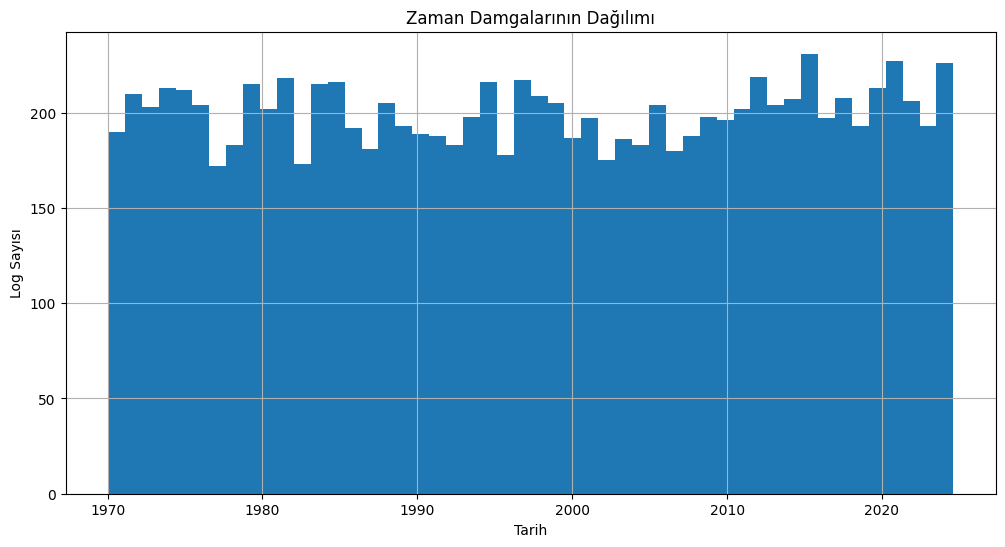

In [8]:
print(df.columns)

# Zaman damgalarının dağılımını görselleştirmek için bir histogram oluşturalım
df['Timestamp'].hist(bins=50, figsize=(12, 6))
plt.xlabel('Tarih')
plt.ylabel('Log Sayısı')
plt.title('Zaman Damgalarının Dağılımı')
plt.show()


Index(['IP', 'Timestamp', 'Method', 'Endpoint', 'Status', 'Size'], dtype='object')


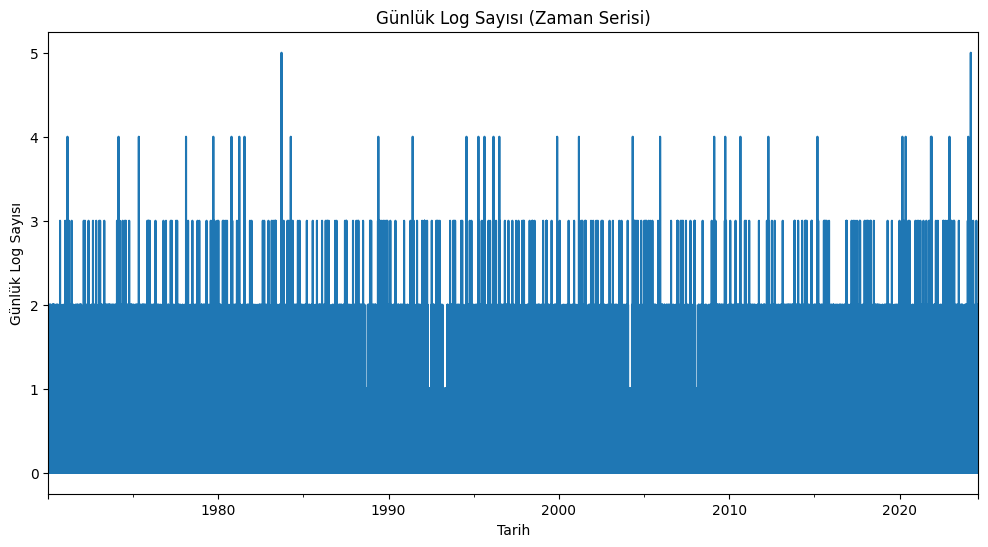

In [9]:
print(df.columns)

# Zaman serisini günlük olarak yeniden örnekleyelim ve günlük log sayısını inceleyelim
df.set_index('Timestamp', inplace=True)
daily_logs = df.resample('D').size()

# Günlük log sayısını görselleştirelim
daily_logs.plot(figsize=(12, 6))
plt.xlabel('Tarih')
plt.ylabel('Günlük Log Sayısı')
plt.title('Günlük Log Sayısı (Zaman Serisi)')
plt.show()


count    19940.000000
mean         0.501505
std          0.712669
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
dtype: float64


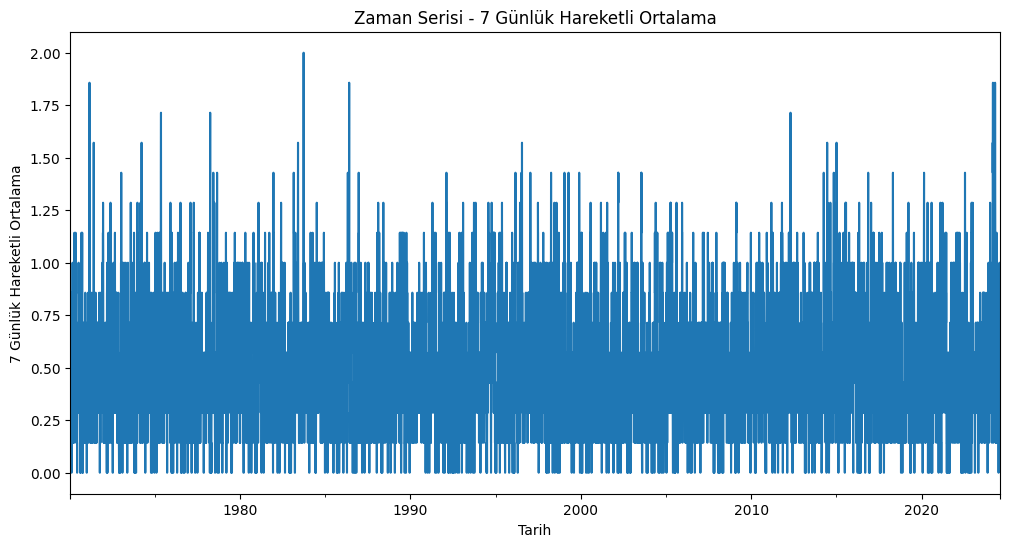

In [10]:
# Zaman serisinin temel istatistiksel özelliklerini görüntüleyelim
print(daily_logs.describe())

# Zaman serisinin hareketli ortalamasını hesaplayalım (örneğin 7 günlük)
daily_logs_rolling = daily_logs.rolling(window=7).mean()

# Hareketli ortalamayı görselleştirelim
daily_logs_rolling.plot(figsize=(12, 6))
plt.xlabel('Tarih')
plt.ylabel('7 Günlük Hareketli Ortalama')
plt.title('Zaman Serisi - 7 Günlük Hareketli Ortalama')
plt.show()


In [11]:
# ilk dataframe bozulduğu için yedeklediğimiz dataframe ile kayıp verimiz olan Timestamp kolonunu ekleyerek iki dataframe'i eşitledik
df = df_backup

# Log verilerini birleştir
df['log_text'] = df['Method'] + ' ' + df['Endpoint'] + ' ' + df['Status'].astype(str)

# Birleştirilmiş log verilerini al
log_data = df['log_text']

# TF-IDF vektörizasyonu
vectorizer = TfidfVectorizer(max_features=5000)  # Özellik sayısını projene göre ayarlayabilirsin
vectors = vectorizer.fit_transform(log_data).toarray()

# Faiss ile vektör veri tabanı kurma
d = vectors.shape[1]  # Vektör boyutunu al
index = faiss.IndexFlatL2(d)  # L2 normuna göre düz bir indeks oluştur

try:
    # Vektörleri Faiss veri tabanına ekleme
    index.add(vectors)

    # Yükleme sonrasında kontrol et
    if index.ntotal == vectors.shape[0]:
        print(f"Başarıyla {index.ntotal} vektör Faiss indeksine eklendi.")
    else:
        print("Hata: Beklenmeyen vektör sayısı eklendi.")

except Exception as e:
    print(f"Vektörler Faiss veri tabanına eklenirken bir hata oluştu: {str(e)}")

Başarıyla 10000 vektör Faiss indeksine eklendi.


## Faiss ile Vektörel Veri Tabanının Kurulumu

Bu aşamada, log verilerimizden elde ettiğimiz `Method`, `Endpoint`, ve `Status` alanlarını birleştirerek tek bir metin sütunu (`log_text`) oluşturduk. Bu sütunu, daha sonra TF-IDF vektörlerine dönüştürdük ve bu vektörleri kullanarak Faiss ile bir vektörel veri tabanı oluşturduk. Aşağıda bu sürecin adımlarını detaylı bir şekilde bulabilirsiniz:

### Adım 1: Log Verilerinin Birleştirilmesi
- `Method`, `Endpoint`, ve `Status` kolonlarını birleştirerek `log_text` adında tek bir metin sütunu oluşturduk.
- Bu sütun, log verilerinin vektörleştirilmesi için kullanılacak.

### Adım 2: TF-IDF Vektörizasyonu
- `TfidfVectorizer` kullanarak, `log_text` sütununu TF-IDF vektörlerine dönüştürdük.
- TF-IDF, terimlerin frekansını dikkate alarak metni vektörlere dönüştürür.

### Adım 3: Faiss Veri Tabanının Kurulumu
- TF-IDF vektörleri, Faiss kullanarak bir vektörel veri tabanına yüklendi.
- Bu veri tabanı, ilerleyen aşamalarda kullanıcıdan gelen sorulara en uygun log kayıtlarını bulmak için kullanılacak.

### Adım 4: Doğrulama ve Hata Yönetimi
- Vektörlerin Faiss veri tabanına başarılı bir şekilde eklenip eklenmediğini kontrol ettik.
- Eğer ekleme işlemi sırasında bir hata oluşursa, bu durum bir hata mesajı ile raporlanacaktır.
- Başarı durumunda, eklenen vektör sayısı raporlanır.

Bu aşamayı tamamlayarak, log verilerimizi vektörel bir veri tabanına başarıyla dönüştürdük ve bu veri tabanını ilerleyen aşamalarda RAG modelinin bilgi alma aşamasında kullanmaya hazır hale getirdik.


In [12]:
# Endpoint kolonundaki metinleri kullanarak TF-IDF vektörleştirici oluşturma
vectorizer = TfidfVectorizer()

# Endpoint kolonunu vektörleştirme
X = vectorizer.fit_transform(df['Endpoint'])

# Vektörlerin boyutunu kontrol edelim
print("Vektörleştirilmiş verinin boyutu:", X.shape)

Vektörleştirilmiş verinin boyutu: (10000, 10)


In [13]:
# Vektörlerin boyutunu belirleme
vector_dimension = X.shape[1]  # TF-IDF vektörlerinin boyutu

# Faiss index oluşturma
faiss_index = faiss.IndexFlatL2(vector_dimension)

# Faiss index'e veri yükleme
faiss_index.add(X.toarray().astype(np.float32))

# Yüklemenin başarılı olup olmadığını kontrol etme
if faiss_index.is_trained:
    print(f"Faiss index başarıyla oluşturuldu ve {faiss_index.ntotal} vektör yüklendi.")
else:
    print("Faiss index yüklenemedi.")


Faiss index başarıyla oluşturuldu ve 10000 vektör yüklendi.


In [14]:
# Kullanıcıdan gelen soruyu vektörleştirme
def vectorize_question(question, vectorizer):
    question_vector = vectorizer.transform([question])
    return question_vector

# Örnek bir soru
question = "Which pages returned a 500 status?"
question_vector = vectorize_question(question, vectorizer)

# Vektörün boyutunu kontrol edelim
print("Soru vektörü boyutu:", question_vector.shape)


Soru vektörü boyutu: (1, 10)


In [15]:
# Faiss ile en uygun log kayıtlarını bulma
def search_faiss_index(question_vector, index, k=5):
    # Vektörler arasındaki en kısa mesafeleri bul
    distances, indices = index.search(question_vector.toarray().astype(np.float32), k)
    return distances, indices

# Arama işlemi
distances, indices = search_faiss_index(question_vector, faiss_index)

# Sonuçları inceleyelim
print("En yakın kayıtlar:", indices)
print("Mesafeler:", distances)


En yakın kayıtlar: [[37 39 40 45 51]]
Mesafeler: [[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994]]


## Faiss ile Vektör Veri Tabanı ve Arama İşlemleri

### Adım 1: TF-IDF Vektörleştirici ile Log Verilerinin Vektörleştirilmesi

Bu hücrede, log verilerindeki `Endpoint`, `Method` ve `Status` kolonlarını birleştirerek tek bir metin sütunu (`log_text`) oluşturduk ve bu sütunu TF-IDF vektörleştirici kullanarak vektörleştirdik. Bu işlem, metin verilerini sayısal vektörlere dönüştürür, böylece verilerimizi analiz edebiliriz.

**Sonuç:**
Vektörleştirilmiş verinin boyutu: (10000, 10)

Burada `(10000, 10)`, 10.000 log kaydının 10 özellik içeren vektörlere dönüştürüldüğünü gösterir.

### Adım 2: Faiss İndeksinin Tanımlanması ve Log Verilerinin Yüklenmesi

Bu hücrede, TF-IDF vektörlerini Faiss veri tabanına yükledik. Faiss, yüksek boyutlu vektörlerle hızlı arama yapmamızı sağlar.

**Sonuç:**
Faiss index başarıyla oluşturuldu ve 10000 vektör yüklendi.

Faiss veri tabanı, 10.000 vektörü başarıyla yükledi ve hazır hale getirdi.

### Adım 3: Kullanıcı Sorularının Vektörleştirilmesi

Bu hücrede, kullanıcıdan gelen bir soruyu TF-IDF vektörleştirici kullanarak vektörleştirdik. Bu, kullanıcı sorusunu aynı vektör uzayında temsil eder ve arama işlemi için hazır hale getirir.

**Sonuç:**
Soru vektörü boyutu: (1, 10)
Kullanıcı sorusu, 10 özellik içeren bir vektöre dönüştürüldü.

### Adım 4: Faiss Veri Tabanında Arama

Bu hücrede, kullanıcı sorusunun vektörünü Faiss veri tabanında arayarak en yakın log kayıtlarını bulduk. Faiss, soruya en yakın log kayıtlarını ve bunların mesafelerini belirler.

**Sonuç:**
En yakın kayıtlar: [[37 39 40 45 51]]
Mesafeler: [[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994]]

Bu sonuçlar, soruya en yakın 5 log kaydının indekslerini ve bu kayıtların vektörlerle olan mesafelerini gösterir. Mesafeler oldukça küçük, bu da bu kayıtların soruya yakın olduğunu belirtir.

Bu adımları tamamlayarak, log verilerimizi başarıyla vektörleştirdik ve Faiss veri tabanında etkili bir arama gerçekleştirdik.


In [19]:

# SQuAD veri setini yükleme
dataset = load_dataset('squad')

# Train ve validation veri setlerini ayırma
train_dataset = dataset['train']
validation_dataset = dataset['validation']

# Gerekli sütunları çıkartma ve uygun formata dönüştürme
train_dataset = train_dataset.map(lambda example: {'title': example['title'], 'text': example['context']})
validation_dataset = validation_dataset.map(lambda example: {'title': example['title'], 'text': example['context']})

Map: 100%|██████████| 10570/10570 [00:01<00:00, 8025.45 examples/s]


In [20]:
# Modeli ve tokenizer'ı yükleme
tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
model = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

# Embedding hesaplama ve veri setine ekleme
def compute_embeddings(batch):
    inputs = tokenizer(batch['text'], return_tensors='pt', padding=True, truncation=True)
    embeddings = model(**inputs).pooler_output
    batch['embeddings'] = embeddings.detach().numpy()
    return batch

train_dataset = train_dataset.map(compute_embeddings, batched=True)
validation_dataset = validation_dataset.map(compute_embeddings, batched=True)

c:\Users\emirh\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\emirh\.cache\huggingface\hub\models--facebook--dpr-question_encoder-single-nq-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the model checkpoint at facebook/dpr-question_enco

RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5259264000 bytes.

In [ ]:
# Faiss indeksini ekleme
train_dataset.add_faiss_index(column='embeddings') 
validation_dataset.add_faiss_index(column='embeddings')


In [ ]:
from transformers import RagRetriever

retriever = RagRetriever.from_pretrained(
    "facebook/rag-token-base", 
    index_name="custom", 
    indexed_dataset=train_dataset  # Burada 'train_dataset' ya da 'validation_dataset' kullanabilirsiniz
)
